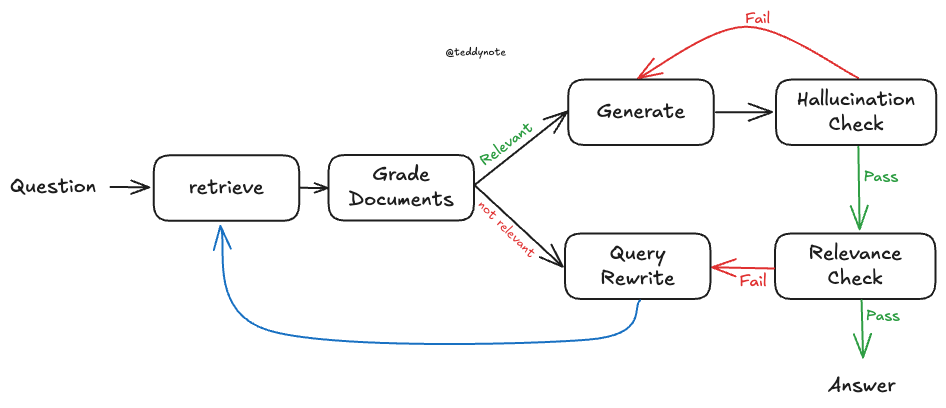

# 메인

## 환경 설정

In [1]:
# OpenAI API 키 설정
import os
from getpass import getpass

# API 키가 환경 변수에 없으면 입력 요청
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("OpenAI API Key: ")


## 문서 로드 및 인덱싱

In [ ]:
# 데이터 로드 및 분할
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

# 예시 URL에서 문서 로드
urls = [
    "https://en.wikipedia.org/wiki/Retrieval-augmented_generation",
    "https://en.wikipedia.org/wiki/Large_language_model"
]
loader = WebBaseLoader(urls)
documents = loader.load()

# 문서 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100
)
splits = text_splitter.split_documents(documents)

# 벡터 저장소 생성
embedding = OpenAIEmbeddings()
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory="./chroma_db"
)

# 리트리버 정의
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 4}
)


## 검색 필요성 평가 구현 (Retrieve 토큰)

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.chains import LLMChain
from typing import Dict
from pydantic import BaseModel, Field

# Retrieve 결정을 위한 출력 구조
class RetrievalDecision(BaseModel):
    decision: str = Field(description="검색 필요 여부 (yes 또는 no)")

# Retrieve 결정을 위한 프롬프트 정의
retrieve_prompt_template = """
당신은 정보 검색이 필요한지 여부를 판단하는 전문가입니다.
주어진 질문에 답하기 위해 외부 정보 검색이 필요한지 판단하세요.

사실 기반 지식이나 최신 정보가 필요한 질문이면 검색이 필요합니다.
일반적인 상식, 논리적 추론만으로 답변 가능한 질문이면 검색이 필요하지 않습니다.

질문: {question}

검색이 필요한지 yes 또는 no로만 답변하세요:
"""

retrieve_prompt = ChatPromptTemplate.from_template(retrieve_prompt_template)

# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

# 구조화된 출력을 위한 LLM 정의
structured_llm = llm.with_structured_output(RetrievalDecision)

# 검색 필요성 평가 체인
retrieval_decision_chain = LLMChain(
    llm=structured_llm,
    prompt=retrieve_prompt,
    output_key="retrieval_decision"
)

def should_retrieve(question: str) -> bool:
    """질문을 분석하여 검색이 필요한지 결정합니다."""
    result = retrieval_decision_chain.run(question=question)
    return result.decision.strip().lower() == "yes"


## 검색된 문서 관련성 평가 (Relevance 토큰)

In [ ]:
from pydantic import BaseModel, Field
from typing import List, Dict, Optional, Tuple
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from langchain.docstore.document import Document
import asyncio

# 간소화된 관련성 평가 기준 및 가중치 정의
RELEVANCE_CRITERIA_WEIGHTS = {
    "topic_relevance": 1.2,     # 주제 관련성
    "information_value": 1.5,   # 정보 가치
    "factual_quality": 1.3,     # 사실적 품질
    "completeness": 1.0,        # 완전성
    "temporal_relevance": 0.8   # 시간적 관련성
}

# 가중치의 합 계산
TOTAL_WEIGHTS = sum(RELEVANCE_CRITERIA_WEIGHTS.values())

# 임계값 설정
DISCARD_THRESHOLD = 0.33  # 이 점수 미만은 폐기
KEEP_THRESHOLD = 0.66     # 이 점수 이상은 유지

# 증강 시도 최대 횟수 설정
MAX_ENHANCEMENT_ATTEMPTS = 3

# 각 기준별 개별 평가 모델
class TopicRelevanceScore(BaseModel):
    score: int = Field(description="주제 관련성 점수 (0 또는 1)")
    reasoning: str = Field(description="평가 근거")

class InformationValueScore(BaseModel):
    score: int = Field(description="정보 가치 점수 (0 또는 1)")
    reasoning: str = Field(description="평가 근거")

class FactualQualityScore(BaseModel):
    score: int = Field(description="사실적 품질 점수 (0 또는 1)")
    reasoning: str = Field(description="평가 근거")

class CompletenessScore(BaseModel):
    score: int = Field(description="완전성 점수 (0 또는 1)")
    reasoning: str = Field(description="평가 근거")

class TemporalRelevanceScore(BaseModel):
    score: int = Field(description="시간적 관련성 점수 (0 또는 1)")
    reasoning: str = Field(description="평가 근거")

# 최종 통합 관련성 점수 모델
class DetailedRelevanceScore(BaseModel):
    criteria_scores: Dict[str, int] = Field(description="각 관련성 기준에 대한 점수 (0 또는 1)")
    criteria_reasoning: Dict[str, str] = Field(description="각 기준 점수에 대한 판단 근거")
    total_score: float = Field(description="전체 관련성 점수 (0~1)")

# 후속 질문 모델
class FollowUpQuestion(BaseModel):
    question: str = Field(description="생성된 후속 질문")

# 문서 처리 결과를 위한 데이터 클래스
class DocumentProcessingResult(BaseModel):
    action: str
    document: str
    score: float
    enhanced_documents: Optional[Dict] = None
    metadata: Optional[Dict] = None

# 각 기준별 프롬프트 템플릿
topic_relevance_template = """
당신은 문서가 질문의 주제와 얼마나 관련이 있는지 평가하는 전문가입니다.

질문: {question}
문서: {document}

주제 관련성(topic_relevance)을 평가해주세요:
- 문서가 질문의 주제 및 핵심 키워드와 관련되어 있는지 평가하세요
- 질문의 핵심 개념이나 키워드가 문서에 포함되어 있는지 확인하세요
- 문서의 전반적인 내용이 질문의 주제와 일치하는지 판단하세요

0(전혀 관련 없음) 또는 1(관련 있음)으로 점수를 매기고, 그 이유를 설명하세요.
"""

information_value_template = """
당신은 문서가 질문에 얼마나 유용한 정보를 제공하는지 평가하는 전문가입니다.

질문: {question}
문서: {document}

정보 가치(information_value)를 평가해주세요:
- 문서가 질문에 직접적으로 답하는 내용을 포함하는지 평가하세요
- 문서의 정보가 질문 해결에 실질적으로 도움이 되는지 판단하세요
- 제공된 정보의 구체성과 명확성을 고려하세요

0(유용한 정보 없음) 또는 1(유용한 정보 있음)으로 점수를 매기고, 그 이유를 설명하세요.
"""

factual_quality_template = """
당신은 문서 내용의 사실적 품질을 평가하는 전문가입니다.

질문: {question}
문서: {document}

사실적 품질(factual_quality)을 평가해주세요:
- 문서의 정보가 사실에 기반하고 있는지 평가하세요
- 정보의 출처나 근거가 명확하게 제시되어 있는지 확인하세요
- 내용이 논리적이고 일관성이 있는지 판단하세요

0(낮은 품질) 또는 1(높은 품질)으로 점수를 매기고, 그 이유를 설명하세요.
"""

completeness_template = """
당신은 문서가 질문에 대해 얼마나 완전한 답변을 제공하는지 평가하는 전문가입니다.

질문: {question}
문서: {document}

완전성(completeness)을 평가해주세요:
- 문서가 질문의 모든 측면을 다루고 있는지 평가하세요
- 추가 정보 없이도 질문에 답할 수 있을 만큼 충분한지 판단하세요
- 중요한 세부 사항이 누락되었는지 확인하세요

0(불완전함) 또는 1(완전함)으로 점수를 매기고, 그 이유를 설명하세요.
"""

temporal_relevance_template = """
당신은 문서의 정보가 시간적으로 적절한지 평가하는 전문가입니다.

질문: {question}
문서: {document}

시간적 관련성(temporal_relevance)을 평가해주세요:
- 질문이 특정 시간대나 최신 정보를 요구한다면, 문서가 그에 부합하는지 평가하세요
- 정보의 시간적 맥락이 질문에 적합한지 판단하세요
- 시간적 요소가 질문에 중요하지 않은 경우 기본적으로 관련성이 있다고 판단하세요

0(시간적으로 부적절함) 또는 1(시간적으로 적절함)으로 점수를 매기고, 그 이유를 설명하세요.
"""

# 후속 질문 생성 프롬프트
follow_up_questions_template = """
당신은 주어진 질문과 문서를 분석하여 관련성을 높이기 위한 추가 질문을 생성하는 전문가입니다.

원본 질문: {question}
검색된 문서: {document}

위 문서는 원본 질문에 대해 부분적으로만 관련성이 있습니다. 
원본 질문에 더 관련된 정보를 검색하기 위한 후속 질문 3개를 생성해주세요.

후속 질문들은:
1. 원본 질문의 맥락을 유지해야 합니다.
2. 문서에 누락된 정보나 부족한 측면을 보완할 수 있어야 합니다.
3. 구체적이고 명확해야 합니다.
4. 검색 시스템이 더 관련성 높은 문서를 찾는 데 도움이 되어야 합니다.

다음 형식으로 3개의 후속 질문만 생성해주세요:
1. [첫 번째 후속 질문]
2. [두 번째 후속 질문]
3. [세 번째 후속 질문]
"""

# LLM 설정
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)

# 비동기 관련성 평가 함수
async def evaluate_detailed_relevance(question: str, document: str) -> DetailedRelevanceScore:
    """문서의 질문 관련성을 5가지 핵심 기준으로 독립적으로 평가합니다."""
    
    # 각 기준별 구조화된 LLM 설정
    topic_llm = llm.with_structured_output(TopicRelevanceScore)
    info_llm = llm.with_structured_output(InformationValueScore)
    factual_llm = llm.with_structured_output(FactualQualityScore)
    completeness_llm = llm.with_structured_output(CompletenessScore)
    temporal_llm = llm.with_structured_output(TemporalRelevanceScore)
    
    # 각 기준별 프롬프트 설정
    topic_prompt = ChatPromptTemplate.from_template(topic_relevance_template)
    info_prompt = ChatPromptTemplate.from_template(information_value_template)
    factual_prompt = ChatPromptTemplate.from_template(factual_quality_template)
    completeness_prompt = ChatPromptTemplate.from_template(completeness_template)
    temporal_prompt = ChatPromptTemplate.from_template(temporal_relevance_template)
    
    # 각 기준별 평가 체인 생성
    topic_chain = LLMChain(llm=topic_llm, prompt=topic_prompt)
    info_chain = LLMChain(llm=info_llm, prompt=info_prompt)
    factual_chain = LLMChain(llm=factual_llm, prompt=factual_prompt)
    completeness_chain = LLMChain(llm=completeness_llm, prompt=completeness_prompt)
    temporal_chain = LLMChain(llm=temporal_llm, prompt=temporal_prompt)
    
    # 병렬로 각 기준 평가 실행
    topic_task = asyncio.create_task(
        asyncio.to_thread(topic_chain.run, question=question, document=document)
    )
    info_task = asyncio.create_task(
        asyncio.to_thread(info_chain.run, question=question, document=document)
    )
    factual_task = asyncio.create_task(
        asyncio.to_thread(factual_chain.run, question=question, document=document)
    )
    completeness_task = asyncio.create_task(
        asyncio.to_thread(completeness_chain.run, question=question, document=document)
    )
    temporal_task = asyncio.create_task(
        asyncio.to_thread(temporal_chain.run, question=question, document=document)
    )
    
    # 모든 평가 결과 수집
    topic_result = await topic_task
    info_result = await info_task
    factual_result = await factual_task
    completeness_result = await completeness_task
    temporal_result = await temporal_task
    
    # 점수와 근거 추출
    criteria_scores = {
        "topic_relevance": topic_result.score,
        "information_value": info_result.score,
        "factual_quality": factual_result.score,
        "completeness": completeness_result.score,
        "temporal_relevance": temporal_result.score
    }
    
    criteria_reasoning = {
        "topic_relevance": topic_result.reasoning,
        "information_value": info_result.reasoning,
        "factual_quality": factual_result.reasoning,
        "completeness": completeness_result.reasoning,
        "temporal_relevance": temporal_result.reasoning
    }
    
    # 가중치를 적용한 총점 계산
    weighted_score = 0
    for criterion, score in criteria_scores.items():
        weight = RELEVANCE_CRITERIA_WEIGHTS.get(criterion, 1.0)
        weighted_score += score * weight
    
    # 정규화된 가중 점수 계산
    normalized_weighted_score = weighted_score / TOTAL_WEIGHTS
    
    return DetailedRelevanceScore(
        criteria_scores=criteria_scores,
        criteria_reasoning=criteria_reasoning,
        total_score=normalized_weighted_score
    )

# 관련성 구간에 따른 문서 처리 함수
async def process_document_by_relevance(question: str, document: str, metadata: Optional[Dict] = None) -> DocumentProcessingResult:
    """관련성 점수에 따라 문서를 처리합니다."""
    evaluation = await evaluate_detailed_relevance(question, document)
    relevance_score = evaluation.total_score
    
    if relevance_score < DISCARD_THRESHOLD:
        # 관련성이 낮은 문서는 폐기
        return DocumentProcessingResult(
            action="discard", 
            document=document, 
            score=relevance_score,
            metadata=metadata
        )
    elif relevance_score >= KEEP_THRESHOLD:
        # 관련성이 높은 문서는 유지
        return DocumentProcessingResult(
            action="keep", 
            document=document, 
            score=relevance_score,
            metadata=metadata
        )
    else:
        # 관련성이 중간인 문서는 증강
        enhanced_docs = await enhance_relevance(question, document)
        return DocumentProcessingResult(
            action="enhance", 
            document=document, 
            score=relevance_score, 
            enhanced_documents=enhanced_docs,
            metadata=metadata
        )

# 후속 질문 생성 함수
def generate_follow_up_questions(question: str, document: str) -> List[FollowUpQuestion]:
    """문서의 관련성을 높이기 위한 후속 질문을 생성합니다."""
    # 후속 질문 생성 프롬프트 설정
    follow_up_prompt = ChatPromptTemplate.from_template(follow_up_questions_template)
    
    # LLM 체인 설정
    follow_up_chain = LLMChain(llm=llm, prompt=follow_up_prompt)
    
    # 후속 질문 생성
    response = follow_up_chain.run(question=question, document=document)
    
    # 응답에서 질문 추출
    follow_up_questions = []
    lines = response.strip().split('\n')
    
    for line in lines:
        if not line.strip():
            continue
            
        if line.startswith('1.') or line.startswith('2.') or line.startswith('3.'):
            question_text = line[2:].strip()
            if question_text:
                follow_up_questions.append(FollowUpQuestion(question=question_text))
    
    return follow_up_questions

# 관련성 강화 함수
async def enhance_relevance(question: str, document: str) -> Dict:
    """문서의 관련성을 향상시키기 위한 후속 질문을 생성하고 처리합니다."""
    follow_up_questions = generate_follow_up_questions(question, document)
    
    return {
        "original_document": document,
        "follow_up_questions": follow_up_questions,
        "additional_documents": []  # 실제 검색 시 채워질 부분
    }

# 후속 질문을 사용한 검색 함수
async def search_with_question(question: str, retriever) -> List[Tuple[str, Dict]]:
    """후속 질문을 사용하여 문서를 검색합니다."""
    docs = retriever.get_relevant_documents(question)
    return [(doc.page_content, doc.metadata) for doc in docs]

# 문서 병합 및 재평가 함수
async def combine_and_reevaluate(question: str, original_doc: str, additional_docs: List[Tuple[str, Dict]]) -> tuple:
    """원본 문서와 추가 문서를 이어붙이고 관련성을 재평가합니다."""
    # 원본 문서와 추가 문서를 HTML과 유사한 태그 형식으로 이어붙이기
    combined_doc = f"<원본문서>{original_doc}</원본문서>"
    
    for i, (doc, _) in enumerate(additional_docs, 1):
        combined_doc += f"\n<추가문서-{i}>{doc}</추가문서-{i}>"
    
    # 병합된 문서의 관련성 재평가
    evaluation = await evaluate_detailed_relevance(question, combined_doc)
    return evaluation.total_score, combined_doc

# 로깅 함수
def log_processing_result(result: DocumentProcessingResult, question: str):
    """문서 처리 결과를 로깅합니다."""
    print(f"질문: {question}")
    print(f"액션: {result.action}")
    print(f"점수: {result.score:.2f}")
    if result.enhanced_documents and result.enhanced_documents.get("follow_up_questions"):
        print("생성된 후속 질문들:")
        for i, q in enumerate(result.enhanced_documents.get("follow_up_questions", []), 1):
            print(f"  {i}. {q.question}")
    print("-" * 50)

# 메인 문서 처리 함수
async def process_documents_by_relevance(question: str, retriever) -> List[Document]:
    """문서의 관련성을 평가하고 필요시 증강하여 관련 문서만 반환합니다."""
    print(f"질문 처리 시작: '{question}'")
    
    # 초기 문서 검색
    retrieved_docs = retriever.get_relevant_documents(question)
    print(f"{len(retrieved_docs)}개 문서 검색됨")
    
    relevant_docs = []
    processing_tasks = []
    
    # 문서별 처리 작업 생성
    for doc in retrieved_docs:
        task = process_document_by_relevance(question, doc.page_content, doc.metadata)
        processing_tasks.append(task)
    
    # 병렬 처리 실행
    processing_results = await asyncio.gather(*processing_tasks)
    
    # 결과 처리
    for result in processing_results:
        log_processing_result(result, question)
        
        if result.action == "keep":
            # 관련성 높은 문서는 바로 추가
            relevant_docs.append(Document(
                page_content=result.document, 
                metadata=result.metadata or {}
            ))
        
        elif result.action == "enhance":
            # 관련성 애매한 문서는 강화 처리
            enhanced_result = result.enhanced_documents
            additional_docs = []
            
            # 후속 질문으로 추가 검색 수행 (증강 횟수 제한 추가)
            attempt_count = 0
            current_score = result.score
            current_text = result.document
            
            while attempt_count < MAX_ENHANCEMENT_ATTEMPTS and current_score < KEEP_THRESHOLD:
                attempt_count += 1
                print(f"문서 증강 시도 {attempt_count}/{MAX_ENHANCEMENT_ATTEMPTS}")
                
                temp_additional_docs = []
                for follow_up in enhanced_result.get("follow_up_questions", []):
                    follow_up_question = follow_up.question
                    if follow_up_question:
                        print(f"후속 질문으로 검색: '{follow_up_question}'")
                        additional_results = await search_with_question(follow_up_question, retriever)
                        temp_additional_docs.extend(additional_results)
                
                if not temp_additional_docs:
                    print("추가 문서를 찾을 수 없어 증강 중단")
                    break
                
                # 문서 병합 및 재평가
                new_score, combined_text = await combine_and_reevaluate(
                    question, 
                    current_text, 
                    temp_additional_docs
                )
                
                print(f"재평가 결과: 점수 {current_score:.2f} -> {new_score:.2f}")
                
                # 점수가 향상되지 않으면 중단
                if new_score <= current_score:
                    print("점수 향상 없음, 증강 중단")
                    break
                
                # 현재 상태 업데이트
                current_score = new_score
                current_text = combined_text
                additional_docs.extend(temp_additional_docs)
                
                # 관련성 점수가 임계값을 넘으면 중단
                if current_score >= KEEP_THRESHOLD:
                    print(f"충분한 관련성 달성 (점수: {current_score:.2f})")
                    break
            
            # 최종 점수가 임계값을 넘으면 문서 추가
            if current_score >= KEEP_THRESHOLD:
                enhanced_metadata = result.metadata or {}
                # 증강에 사용된 정보 추가
                enhanced_metadata.update({
                    'enhanced': True,
                    'original_score': result.score,
                    'enhanced_score': current_score,
                    'enhancement_attempts': attempt_count
                })
                
                new_doc = Document(
                    page_content=current_text, 
                    metadata=enhanced_metadata
                )
                relevant_docs.append(new_doc)
                print(f"향상된 문서 추가됨 (점수: {current_score:.2f})")
    
    print(f"관련성 평가 완료: {len(relevant_docs)}개 문서가 선택됨")
    return relevant_docs

# # 사용 예시
# async def test_relevance_system(retriever, question: str = "트럼프는 정확히 몇년 몇월 몇일 몇시에 태어났어?"):
#     """관련성 평가 및 증강 시스템 테스트"""
#     print(f"질문: '{question}'에 대한 관련성 평가 및 증강 테스트 시작")
    
#     # 관련성 평가 및 증강 수행
#     relevant_docs = await process_documents_by_relevance(question, retriever)
    
#     # 결과 출력
#     print("\n=== 관련성 평가 및 증강 결과 ===")
#     print(f"관련 문서 수: {len(relevant_docs)}")
#     for i, doc in enumerate(relevant_docs, 1):
#         print(f"\n문서 {i}:")
#         print(f"내용: {doc.page_content[:150]}..." if len(doc.page_content) > 150 else doc.page_content)
#         print(f"메타데이터: {doc.metadata}")
    
#     return relevant_docs

## 사실성 검증 구현 (Support 토큰)

In [ ]:
# 생성된 텍스트의 사실성 검증을 위한 출력 구조
class SupportAssessment(BaseModel):
    support_level: str = Field(
        description="지원 수준: 'fully supported', 'partially supported', 'no support' 중 하나"
    )
    reasoning: str = Field(description="평가 이유")

# 사실성 평가를 위한 프롬프트
support_prompt_template = """
당신은 생성된 텍스트가 제공된 문서에 의해 얼마나 사실적으로 뒷받침되는지 평가하는 전문가입니다.
생성된 텍스트의 모든 검증 가능한 주장이 문서에 의해 지원되는지 평가하세요.

질문: {question}
문서: {document}
생성된 텍스트: {generated_text}

다음 중 하나로 사실성 수준을 평가하세요:
- fully supported: 모든 주장이 문서에 의해 완전히 지원됨
- partially supported: 일부 주장만 문서에 의해 지원됨
- no support: 주요 주장이 문서에 의해 지원되지 않음

평가 결과:
- 지원 수준: 
- 평가 이유: 
"""

support_prompt = ChatPromptTemplate.from_template(support_prompt_template)
support_llm = llm.with_structured_output(SupportAssessment)

# 사실성 평가 체인
support_chain = LLMChain(
    llm=support_llm,
    prompt=support_prompt,
    output_key="support_assessment"
)

def evaluate_support(question: str, document: str, generated_text: str) -> SupportAssessment:
    """생성된 텍스트의 사실성을 평가합니다."""
    return support_chain.run(
        question=question, 
        document=document, 
        generated_text=generated_text
    )


## 유용성 평가 구현 (Utility 토큰)

In [ ]:
# 생성된 답변의 유용성 평가를 위한 출력 구조
class UtilityAssessment(BaseModel):
    utility_score: int = Field(description="1부터 5까지의 유용성 점수")
    reasoning: str = Field(description="점수를 부여한 이유")

# 유용성 평가를 위한 프롬프트
utility_prompt_template = """
당신은 생성된 답변이 질문에 얼마나 유용한지 평가하는 전문가입니다.
1~5점 척도로 유용성을 평가하세요 (1: 전혀 유용하지 않음, 5: 매우 유용함).

질문: {question}
생성된 답변: {generated_text}

다음 측면을 고려하세요:
1. 질문에 직접적으로 답변하는가
2. 충분한 정보를 제공하는가
3. 명확하고 이해하기 쉬운가
4. 정확한 정보를 제공하는가

유용성 평가:
- 점수(1-5): 
- 평가 이유: 
"""

utility_prompt = ChatPromptTemplate.from_template(utility_prompt_template)
utility_llm = llm.with_structured_output(UtilityAssessment)

# 유용성 평가 체인
utility_chain = LLMChain(
    llm=utility_llm,
    prompt=utility_prompt,
    output_key="utility_assessment"
)

def evaluate_utility(question: str, generated_text: str) -> UtilityAssessment:
    """생성된 답변의 유용성을 평가합니다."""
    return utility_chain.run(question=question, generated_text=generated_text)


## 답변 생성 구현

In [ ]:
from langchain.output_parsers import StrOutputParser

# 답변 생성을 위한 프롬프트
generation_prompt_template = """
당신은 질문에 답변하는 도우미입니다. 다음 정보를 사용하여 질문에 답하세요.

질문: {question}

검색된 정보:
{context}

검색된 정보를 바탕으로 질문에 답하세요. 검색된 정보에 없는 내용은 지어내지 마세요.
응답은 간결하고 명확해야 합니다.

답변:
"""

generation_prompt = ChatPromptTemplate.from_template(generation_prompt_template)

# 답변 생성 파이프라인
generator = generation_prompt | llm | StrOutputParser()

def generate_answer(question: str, context: str) -> str:
    """검색된 문서를 바탕으로 답변을 생성합니다."""
    return generator.invoke({"question": question, "context": context})
